# DT with Geometric centers on figures a,b,c,d in TR


In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(font_scale=1)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import math
from collections import OrderedDict 
import os
from numpy import mean, std
from random import randint
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.svm import SVC
%matplotlib inline

In [45]:
# Reading The Data From Excel Sheet #
df = pd.read_excel('UoC_dataset.xlsx')
df.head()

,State,Account length,Area code,Phone number,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,...,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Number customer service calls,Churner
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [46]:
def PCAtransform (X, y, shift = 0,drawing = True):
    pca = PCA(n_components=2)
    X_stand = StandardScaler().fit_transform(X) # standardization of feature values (mean=0, variance=1)
    X_pca = pca.fit_transform(X_stand) # fitting the model and reduction of the dimensionality
    redclass_x  = []
    Blueclass_x = []
    #print(type(X_pca))
    # making X-shift of Blue data or Black Data
    for i in range(len(y)):
        if y[i] == 'Blue' or y[i] == "Black":
            #print("in condition")
            X_pca[i,0] = X_pca[i,0] + shift
            Blueclass_x.append(X_pca[i,0])
        elif y[i] =='red':
            redclass_x.append(X_pca[i,0])
    
#     print('X = \n' , X['Account Length'][0:5])
#     print("type of X", type(X))
    
#     print("type of X_pca", type(X_pca))
#     print('X_pca = \n' , X_pca[:,0])
    
    columns = {'A':X_pca[:,0] , 'B':X_pca[:,1]}

    df2 = pd.DataFrame(columns)
    
#     print ('type of df2' , type(df2))
#     print('df2 = \n' , df2['A'])
    
    if drawing == True:
        #plt.axis((-6,15,-6,6))
        PCAplot = plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
        print('redclass_x: mean=%.3f stdv=%.3f' % (mean(redclass_x[:]), std(redclass_x[:])))
        print('Blueclass_x: mean=%.3f stdv=%.3f' % (mean(Blueclass_x[:]), std(Blueclass_x[:])))
        print('---------------------------')
        print("Majority = " , len(redclass_x))
        print("Minority = " , len(Blueclass_x))
    return df2


def Draw():
    plt.axis((-6,15,-6,6))
    PCAplot = plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
    

In [47]:
def ret_random_k_nearest_neighbour( cur , minority_df , k ) :
    dict = {}
    for i in  range(0,minority_df.shape[0])  :
        dict[np.linalg.norm(cur-minority_df.iloc[i])] = minority_df.iloc[i].name 
    dict1 = sorted(dict.items()) 
    return dict1 

In [48]:
def solve(minority_df , want , k = 5  , sigma = 0.5 ):
    so_far = 0 
    dict = {}
    samples = []
    for i in  range(0,minority_df.shape[0])  :
            dict[minority_df.iloc[i].name] = ret_random_k_nearest_neighbour(minority_df.iloc[i] , minority_df , k )
    samples = []
    ss= StandardScaler()
    X_ss= ss.fit_transform(minority_df)
    while so_far != want :
      for i , j  in dict.items():
        value = randint( 0 , k - 1 ) # Normal distribution 
        entrydf = list(j)[value][1] 
        s0 = minority_df.loc[i] + (minority_df.loc[entrydf] - minority_df.loc[i]) * np.random.random_sample()
        R = np.random.normal( s0 , sigma )
        samples.append( R )
        so_far = so_far + 1
        if so_far == want :
          break
    return np.vstack( [ minority_df , ss.inverse_transform( np.vstack( samples ) ) ] )

In [49]:
def data_preprocess(df):
    drop_columns = ["State", "Phone number"]
    df = df.drop(drop_columns, axis=1)
    int_plan_yes = df["International plan"] == ' yes'
    int_plan_no = df["International plan"] == ' no'
    df["International plan"].values[int_plan_yes] = 1
    df["International plan"].values[int_plan_no] = 0
    voice_plan_no = df["Voice mail plan"] == ' no'
    voice_plan_yes = df["Voice mail plan"] == ' yes'
    df["Voice mail plan"].values[voice_plan_yes] = 1
    df["Voice mail plan"].values[voice_plan_no] = 0
    churner_yes = df['Churner'] == ' True.'
    churner_no = df['Churner'] == ' False.'
    df["Churner"].values[churner_yes] = 1
    df["Churner"].values[churner_no] = 0
    df['Churner'] = df['Churner'].apply(pd.to_numeric)
    return (df)

In [50]:
df = data_preprocess(df)

In [51]:
#df
X = df.iloc[:,0:18]             # dataset without last column
y = df.iloc[:,18]               # just a last column
X, _, y, _ = train_test_split(X, y, test_size=.6, random_state=0)

In [52]:
X.sample(5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=0)
color = []
z = y.tolist()
for i in range (0,len(z)):
    if(z[i] == 0):
        color.append('red')
    elif (z[i] == 1):
        color.append('Blue')

redclass_x: mean=-0.044 stdv=1.453
Blueclass_x: mean=10.254 stdv=1.482
---------------------------
Majority =  1137
Minority =  196
(1137, 3)
(1137, 3)


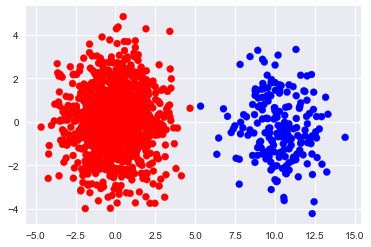

In [54]:
# To Generate Figure (a)
s = PCAtransform( X , color , 10 )
X_train_fig_a, X_test_fig_a, y_train_fig_a, y_test_fig_a = train_test_split( s , y , test_size=.4, random_state=0)
listt = [i for i in range(0 , s.shape[0])]
E = pd.Series(listt)

E.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
s.reset_index(drop=True, inplace=True)

T = pd.concat([s,y,E],axis=1)
T.rename(columns={0:"name"} , inplace=True)
T = T.set_index("name")
minority_df = T[T["Churner"] == 1 ]
majority_df = T[T["Churner"] == 0 ]
R = minority_df.drop("Churner",axis=1)
E = solve( R , majority_df.shape[0]-minority_df.shape[0] )
new_minority = pd.DataFrame( E , columns = minority_df.columns[ : -1 ] )
new_minority["Churner"] = 1
print(new_minority.shape)
print( majority_df.shape  )


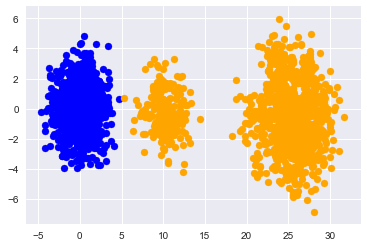

In [55]:
fig, ax = plt.subplots()
PCAplot = ax.scatter(majority_df.iloc[:,0], majority_df.iloc[:,1], c = 'blue')
#PCAplot = ax.scatter(minority_df__[:,0], minority_df__[:,1], c = minority_df.iloc[:,-1] )
PCAplot = ax.scatter(new_minority.iloc[:,0], new_minority.iloc[:,1], c = 'orange' )
#PCAplot = ax.scatter(minority_df__[:,0], minority_df__[:,1], c = minority_df.iloc[:,-1] )


redclass_x: mean=0.045 stdv=1.453
Blueclass_x: mean=6.741 stdv=1.480
---------------------------
Majority =  1137
Minority =  196
(1137, 3)
(1137, 3)


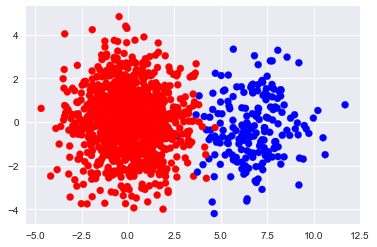

In [56]:
# To Generate Figure (b)
s = PCAtransform(X, color,7)
X_train_fig_a, X_test_fig_a, y_train_fig_a, y_test_fig_a = train_test_split( s , y , test_size=.4, random_state=0)
listt = [i for i in range(0 , s.shape[0])]
E = pd.Series(listt)

E.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
s.reset_index(drop=True, inplace=True)

T = pd.concat([s,y,E],axis=1)
T.rename(columns={0:"name"} , inplace=True)
T = T.set_index("name")
minority_df = T[T["Churner"] == 1 ]
majority_df = T[T["Churner"] == 0 ]
R = minority_df.drop("Churner",axis=1)
E = solve( R , majority_df.shape[0]-minority_df.shape[0] )
new_minority = pd.DataFrame( E , columns = minority_df.columns[ : -1 ] )
new_minority["Churner"] = 1
print(new_minority.shape)
print( majority_df.shape  )




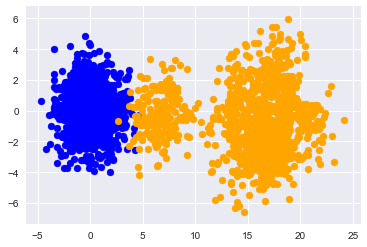

In [57]:
fig, ax = plt.subplots()
PCAplot = ax.scatter(majority_df.iloc[:,0], majority_df.iloc[:,1], c = 'blue')
#PCAplot = ax.scatter(minority_df__[:,0], minority_df__[:,1], c = minority_df.iloc[:,-1] )

PCAplot = ax.scatter(new_minority.iloc[:,0], new_minority.iloc[:,1], c = 'orange' )
#PCAplot = ax.scatter(minority_df__[:,0], minority_df__[:,1], c = minority_df.iloc[:,-1] )


redclass_x: mean=0.043 stdv=1.452
Blueclass_x: mean=2.750 stdv=1.487
---------------------------
Majority =  1137
Minority =  196
(1137, 3)
(1137, 3)


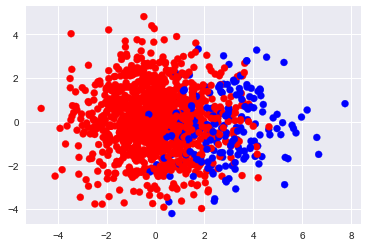

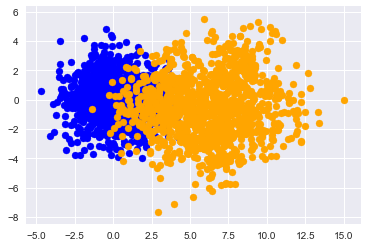

In [58]:
# To Generate Figure between Figure(c)
s = PCAtransform(X, color,3)
X_train_fig_b, X_test_fig_b, y_train_fig_b, y_test_fig_b = train_test_split(s, y, test_size=.4, random_state=0)
listt = [i for i in range(0 , s.shape[0])]
E = pd.Series(listt)

E.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
s.reset_index(drop=True, inplace=True)

T = pd.concat([s,y,E],axis=1)
T.rename(columns={0:"name"} , inplace=True)
T = T.set_index("name")
minority_df = T[T["Churner"] == 1 ]
majority_df = T[T["Churner"] == 0 ]
R = minority_df.drop("Churner",axis=1)
E = solve( R , majority_df.shape[0]-minority_df.shape[0] )
new_minority = pd.DataFrame( E , columns = minority_df.columns[ : -1 ] )
new_minority["Churner"] = 1
print(new_minority.shape)
print( majority_df.shape  )
fig, ax = plt.subplots()
PCAplot = ax.scatter(majority_df.iloc[:,0], majority_df.iloc[:,1], c = 'blue')
#PCAplot = ax.scatter(minority_df__[:,0], minority_df__[:,1], c = minority_df.iloc[:,-1] )
PCAplot = ax.scatter(new_minority.iloc[:,0], new_minority.iloc[:,1], c = 'orange' )
#PCAplot = ax.scatter(minority_df__[:,0], minority_df__[:,1], c = minority_df.iloc[:,-1] )

redclass_x: mean=0.044 stdv=1.452
Blueclass_x: mean=0.744 stdv=1.482
---------------------------
Majority =  1137
Minority =  196
(1137, 3)
(1137, 3)


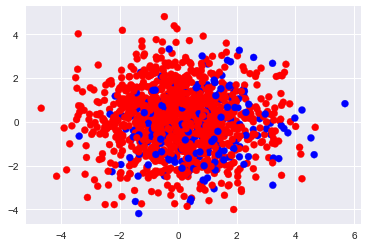

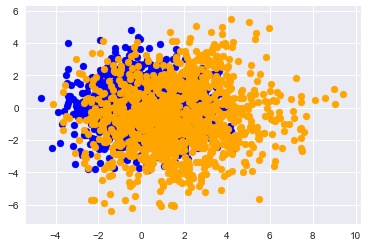

In [59]:
# To Generate Figure between Figure(d)
s = PCAtransform(X, color,1)
X_train_fig_b, X_test_fig_b, y_train_fig_b, y_test_fig_b = train_test_split(s, y, test_size=.4, random_state=0)
listt = [i for i in range(0 , s.shape[0])]
E = pd.Series(listt)

E.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
s.reset_index(drop=True, inplace=True)

T = pd.concat([s,y,E],axis=1)
T.rename(columns={0:"name"} , inplace=True)
T = T.set_index("name")
minority_df = T[T["Churner"] == 1 ]
majority_df = T[T["Churner"] == 0 ]
R = minority_df.drop("Churner",axis=1)
E = solve( R , majority_df.shape[0]-minority_df.shape[0] )
new_minority = pd.DataFrame( E , columns = minority_df.columns[ : -1 ] )
new_minority["Churner"] = 1
print(new_minority.shape)
print( majority_df.shape  )

fig, ax = plt.subplots()
PCAplot = ax.scatter(majority_df.iloc[:,0], majority_df.iloc[:,1], c = 'blue')
#PCAplot = ax.scatter(minority_df__[:,0], minority_df__[:,1], c = minority_df.iloc[:,-1] )

PCAplot = ax.scatter(new_minority.iloc[:,0], new_minority.iloc[:,1], c = 'orange' )
#PCAplot = ax.scatter(minority_df__[:,0], minority_df__[:,1], c = minority_df.iloc[:,-1] )



In [ ]:
# Calculation of metrics
def metricsCalculation(y_test, y_pred):
 acc = accuracy_score(y_test, y_pred)
 precision = precision_score(y_test, y_pred)
 recall = recall_score(y_test, y_pred)
 f =  f1_score(y_test, y_pred)
 tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
 g_mean = np.sqrt((tp/(tp+fn)*(tn/(tn+fp))))
 fpr, tpr, _ = roc_curve(y_test, y_pred)
 #roc_auc = auc(fpr, tpr)
 roc_auc = (1 + (tp/(tp+fn)) - (fp/(fp+tn)))/2
 # Metrics aggregation into dataframe
 res = pd.DataFrame()
 res['OA'] = [acc]
 res['Precision'] = [precision]
 res['Recall'] = [recall]
 res['F measure'] = [f]
 res['G mean'] = [g_mean]
 res['AUC'] = [roc_auc]
 print(confusion_matrix(y_test,y_pred))

 #print (res)

 print('res of OA = {0:.5f}\n'.format(float(res['OA'])))

 print('res of Precision = {0:.5f}\n'.format(float(res['Precision'])))

 print('res of Recall = {0:.5f}\n'.format(float(res['Recall'])))

 print('res of F measure = {0:.5f}\n'.format(float(res['F measure'])))

 print('res of G mean = {0:.5f}\n'.format(float(res['G mean'])))

 print('res of AUC = {0:.5f}\n'.format(float(res['AUC'])))

In [22]:
print("# Train Decision trees of Figure(a) #")


tree_clf = DecisionTreeClassifier()
t0 = time()
tree_clf.fit(X_train_fig_a, y_train_fig_a)
t = time() - t0
y_pred = tree_clf.predict(X_test_fig_a)

metricsCalculation(y_test_fig_a, y_pred)

t=str(t)
print("Execution Time for GBM with default parameters is : "+t+" seconds")
import os
import psutil
#process = psutil.Process(os.getpid())
#print("Memory Usage for DT is ")
#print(process.memory_info().rss)  # in bytes 
#print(process.memory_percent())   # in percentage
#print("Execution Time for DT is : ")
#print(t)

#to print confusion matrix componenets 
cm = confusion_matrix(y_test_fig_a, y_pred)
print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])

# to do some calucations such as acccuracy 
confusion = confusion_matrix(y_test_fig_a, y_pred)
# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
# to check the value of the accuracy
print((TP + TN) / float(TP + TN + FP + FN))

Error_rate= (FP+FN)/(TP + TN + FN + FP)
print ('Error rate is = ', Error_rate)

correct_rate=1-Error_rate
print ('correct rate is = ', correct_rate)

#Type I Accuracy 
print (TP /(TP + FN))

#Type I I Accuracy
print (TN /(TN + FP))

# Train Decision trees of Figure(a) #
[[459   0]
 [  0  75]]
res of OA = 1.00000

res of Precision = 1.00000

res of Recall = 1.00000

res of F measure = 1.00000

res of G mean = 1.00000

res of AUC = 1.00000

Execution Time for GBM with default parameters is : 0.27501559257507324 seconds
True positive =  459
False positive =  0
False negative =  0
True negative =  75
1.0
Error rate is =  0.0
correct rate is =  1.0
1.0
1.0


In [23]:
print("# Train Decision trees of Figure(b) #")


tree_clf = DecisionTreeClassifier()
t0 = time()
tree_clf.fit(X_train_fig_b, y_train_fig_b)
t = time() - t0
y_pred = tree_clf.predict(X_test_fig_b)

metricsCalculation(y_test_fig_b, y_pred)

t=str(t)
print("Execution Time for GBM with default parameters is : "+t+" seconds")
import os
import psutil
#process = psutil.Process(os.getpid())
#print("Memory Usage for DT is ")
#print(process.memory_info().rss)  # in bytes 
#print(process.memory_percent())   # in percentage
#print("Execution Time for DT is : ")
#print(t)

#to print confusion matrix componenets 
cm = confusion_matrix(y_test_fig_b, y_pred)
print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])

# to do some calucations such as acccuracy 
confusion = confusion_matrix(y_test_fig_b, y_pred)
# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
# to check the value of the accuracy
print((TP + TN) / float(TP + TN + FP + FN))

Error_rate= (FP+FN)/(TP + TN + FN + FP)
print ('Error rate is = ', Error_rate)

correct_rate=1-Error_rate
print ('correct rate is = ', correct_rate)

#Type I Accuracy 
print (TP /(TP + FN))

#Type I I Accuracy
print (TN /(TN + FP))

# Train Decision trees of Figure(b) #
[[456   3]
 [  2  73]]
res of OA = 0.99064

res of Precision = 0.96053

res of Recall = 0.97333

res of F measure = 0.96689

res of G mean = 0.98335

res of AUC = 0.98340

Execution Time for GBM with default parameters is : 0.002000093460083008 seconds
True positive =  456
False positive =  3
False negative =  2
True negative =  73
0.9906367041198502
Error rate is =  0.009363295880149813
correct rate is =  0.9906367041198502
0.9733333333333334
0.9934640522875817


In [24]:
print("# Train Decision trees of Figure(c) #")
tree_clf = DecisionTreeClassifier()
t0 = time()
tree_clf.fit(X_train_fig_c, y_train)
t = time() - t0
y_pred = tree_clf.predict(X_test_fig_c)

metricsCalculation(y_test_fig_c, y_pred)

t=str(t)
print("Execution Time for GBM with default parameters is : "+t+" seconds")
import os
import psutil
#process = psutil.Process(os.getpid())
#print("Memory Usage for DT is ")
#print(process.memory_info().rss)  # in bytes 
#print(process.memory_percent())   # in percentage
#print("Execution Time for DT is : ")
#print(t)

#to print confusion matrix componenets 
cm = confusion_matrix(y_test_fig_c, y_pred)
print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])

# to do some calucations such as acccuracy 
confusion = confusion_matrix(y_test_fig_c, y_pred)
# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
# to check the value of the accuracy
print((TP + TN) / float(TP + TN + FP + FN))

Error_rate= (FP+FN)/(TP + TN + FN + FP)
print ('Error rate is = ', Error_rate)

correct_rate=1-Error_rate
print ('correct rate is = ', correct_rate)

#Type I Accuracy 
print (TP /(TP + FN))

#Type I I Accuracy
print (TN /(TN + FP))

# Train Decision trees of Figure(c) #
[[421  38]
 [ 34  41]]
res of OA = 0.86517

res of Precision = 0.51899

res of Recall = 0.54667

res of F measure = 0.53247

res of G mean = 0.70810

res of AUC = 0.73194

Execution Time for GBM with default parameters is : 0.004000186920166016 seconds
True positive =  421
False positive =  38
False negative =  34
True negative =  41
0.8651685393258427
Error rate is =  0.1348314606741573
correct rate is =  0.8651685393258427
0.5466666666666666
0.9172113289760349


In [25]:
print("# Train Decision trees of Figure(d) #")



tree_clf = DecisionTreeClassifier()
t0 = time()
tree_clf.fit(X_train_fig_d, y_train_fig_d)
t = time() - t0
y_pred = tree_clf.predict(X_test_fig_d)

metricsCalculation(y_test_fig_d, y_pred)

t=str(t)
print("Execution Time for GBM with default parameters is : "+t+" seconds")
import os
import psutil
#process = psutil.Process(os.getpid())
#print("Memory Usage for DT is ")
#print(process.memory_info().rss)  # in bytes 
#print(process.memory_percent())   # in percentage
#print("Execution Time for DT is : ")
#print(t)

#to print confusion matrix componenets 
cm = confusion_matrix(y_test_fig_d, y_pred)
print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])

# to do some calucations such as acccuracy 
confusion = confusion_matrix(y_test_fig_d, y_pred)
# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
# to check the value of the accuracy
print((TP + TN) / float(TP + TN + FP + FN))

Error_rate= (FP+FN)/(TP + TN + FN + FP)
print ('Error rate is = ', Error_rate)

correct_rate=1-Error_rate
print ('correct rate is = ', correct_rate)

#Type I Accuracy 
print (TP /(TP + FN))

#Type I I Accuracy
print (TN /(TN + FP))

# Train Decision trees of Figure(d) #
[[387  72]
 [ 60  15]]
res of OA = 0.75281

res of Precision = 0.17241

res of Recall = 0.20000

res of F measure = 0.18519

res of G mean = 0.41064

res of AUC = 0.52157

Execution Time for GBM with default parameters is : 0.0060002803802490234 seconds
True positive =  387
False positive =  72
False negative =  60
True negative =  15
0.7528089887640449
Error rate is =  0.24719101123595505
correct rate is =  0.752808988764045
0.2
0.8431372549019608
